In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable

In [2]:
# Specify the Mean and standard deviation of all the pixels in the MNIST dataset. They are precomputed 
meanGray = 0.1307
stdGray = 0.3081

#Transform the images to tensors
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) 
#for n channels, this transform will normalize each channel of the input torch.Tensor
#i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((meanGray,), (stdGray,))])

#Load our dataset
trainDs = datasets.MNIST(root = './.dataset', train = True, transform = transforms, download = True)

testDs = datasets.MNIST(root = './.dataset',  train = False, transform = transforms)


0it [00:00, ?it/s]

9920512it [00:06, 1645185.17it/s]                             


Extracting ./.dataset/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 96260.33it/s]                            
0it [00:00, ?it/s]

Extracting ./.dataset/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:02, 646970.14it/s]                              
0it [00:00, ?it/s]

Extracting ./.dataset/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 36707.28it/s]            

Extracting ./.dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


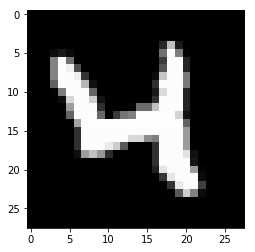

In [5]:
import matplotlib.pyplot as plt
randomImage = trainDs[20][0].numpy() * stdGray + meanGray
plt.imshow(randomImage.reshape(28, 28), cmap='gray')

In [9]:
trainDs[20][1]   #Print the corresponding label for the image


4

In [10]:
bs = 100
epochs = 10

In [11]:
#Make the dataset iterable
trainLoader = torch.utils.data.DataLoader(dataset = trainDs, 
                                         batch_size = bs,
                                         shuffle = True)

testLoader = torch.utils.data.DataLoader(dataset = testDs, 
                                         batch_size = bs,
                                         shuffle = False)

In [12]:

print('There are {} images in the training set'.format(len(trainDs)))
print('There are {} images in the test set'.format(len(testDs)))
print('There are {} batches in the train loader'.format(len(trainLoader)))
print('There are {} batches in the testloader'.format(len(testLoader)))

There are 60000 images in the training set
There are 10000 images in the test set
There are 600 batches in the train loader
There are 100 batches in the testloader


In [13]:
#Create the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #Same Padding = [(filter size - 1) / 2] (Same Padding--> input size = output size)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1, padding=1)
        #The output size of each of the 8 feature maps is 
        #[(input_size - filter_size + 2(padding) / stride) +1] --> [(28-3+2(1)/1)+1] = 28 (padding type is same)
        #Batch normalization
        self.batchnorm1 = nn.BatchNorm2d(8)
        #RELU
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is now 28/2 = 14
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        #Output size of each of the 32 feature maps remains 14
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is 14/2 = 7
        #Flatten the feature maps. You have 32 feature maps, each of them is of size 7x7 --> 32*7*7 = 1568
        self.fc1 = nn.Linear(in_features=1568, out_features=600)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        #Now we have to flatten the output. This is where we apply the feed forward neural network as learned before! 
        #It will take the shape (batch_size, 1568) = (100, 1568)
        out = out.view(-1,1568)
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

In [14]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()    
lossFn = nn.CrossEntropyLoss()        
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [17]:
#Understand what's happening
iteration = 0
correctData = 0
for i,(inputs,labels) in enumerate (trainLoader):
    if iteration==1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    output = model(inputs)
    print("Outputs Shape",output.shape)
    _, predictedNoData = torch.max(output, 1)
    print("Predicted Shape",predictedNoData.shape)
    print("Predicted Tensor:")
    print(predictedNoData)
    _, predictedData = torch.max(output.data, 1) #output.data === output
    correctData += (predictedData == labels.data).sum()
    print("Correct Predictions:",correctData)
    

    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Outputs Shape torch.Size([100, 10])
Predicted Shape torch.Size([100])
Predicted Tensor:
tensor([7, 8, 6, 5, 1, 6, 0, 4, 5, 8, 6, 0, 7, 6, 6, 7, 7, 7, 6, 7, 8, 6, 5, 8,
        7, 8, 8, 2, 8, 5, 2, 5, 7, 6, 8, 8, 6, 9, 1, 2, 2, 7, 8, 7, 6, 6, 7, 8,
        9, 2, 0, 7, 9, 6, 1, 7, 8, 6, 6, 6, 2, 2, 6, 8, 2, 6, 6, 6, 7, 7, 7, 2,
        8, 6, 6, 2, 9, 1, 2, 6, 6, 1, 8, 5, 8, 6, 1, 7, 7, 8, 1, 9, 8, 6, 2, 2,
        7, 7, 6, 2])
Correct Predictions: tensor(10)


In [19]:
#Training the CNN
numOfEpochs = 25

#Define the lists to store the results of loss and accuracy in order to plt them later
trainLoss = []
testLoss = []
trainAccuracy = []
testAccuracy = []

#Training
for epoch in range(numOfEpochs): 
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iterLoss = 0.0
    
    model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(trainLoader):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        # If we have GPU, shift the data to GPU
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)         
        loss = lossFn(outputs, labels)  
        iterLoss += loss.item()         # Accumulate the loss
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    trainLoss.append(iterLoss/iterations)
    # Record the training accuracy
    trainAccuracy.append((100 * correct / len(trainDs)))

    #Testing
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(testLoader):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = lossFn(outputs, labels) # Calculate the loss
        loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    testLoss.append(loss/iterations)
    # Record the Testing accuracy
    testAccuracy.append((100 * correct / len(testDs)))
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, numOfEpochs, trainLoss[-1], trainAccuracy[-1], 
             testLoss[-1], testAccuracy[-1]))

Epoch 1/25, Training Loss: 0.615, Training Accuracy: 85.000, Testing Loss: 0.005, Testing Acc: 95.000
Epoch 2/25, Training Loss: 0.186, Training Accuracy: 94.000, Testing Loss: 0.003, Testing Acc: 96.000
Epoch 3/25, Training Loss: 0.138, Training Accuracy: 96.000, Testing Loss: 0.003, Testing Acc: 97.000
Epoch 4/25, Training Loss: 0.114, Training Accuracy: 96.000, Testing Loss: 0.002, Testing Acc: 97.000
Epoch 5/25, Training Loss: 0.098, Training Accuracy: 97.000, Testing Loss: 0.002, Testing Acc: 97.000
Epoch 6/25, Training Loss: 0.086, Training Accuracy: 97.000, Testing Loss: 0.001, Testing Acc: 98.000
Epoch 7/25, Training Loss: 0.078, Training Accuracy: 97.000, Testing Loss: 0.001, Testing Acc: 98.000
Epoch 8/25, Training Loss: 0.072, Training Accuracy: 97.000, Testing Loss: 0.001, Testing Acc: 98.000
Epoch 9/25, Training Loss: 0.067, Training Accuracy: 98.000, Testing Loss: 0.001, Testing Acc: 98.000
Epoch 10/25, Training Loss: 0.063, Training Accuracy: 98.000, Testing Loss: 0.001,

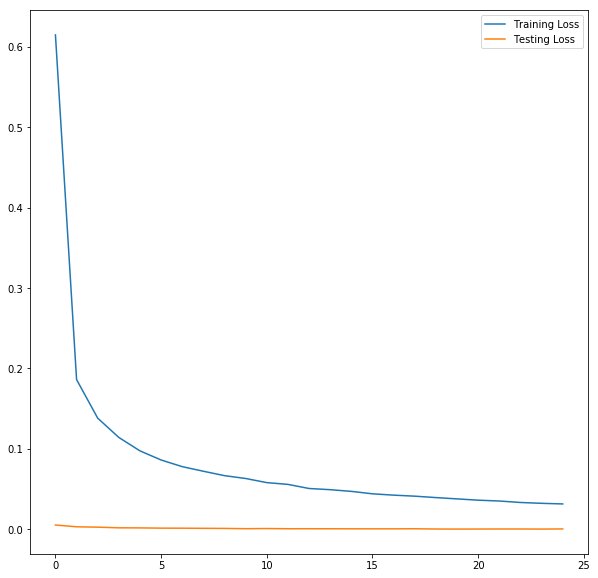

In [21]:
# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(trainLoss, label='Training Loss')
plt.plot(testLoss, label='Testing Loss')
plt.legend()
plt.show()

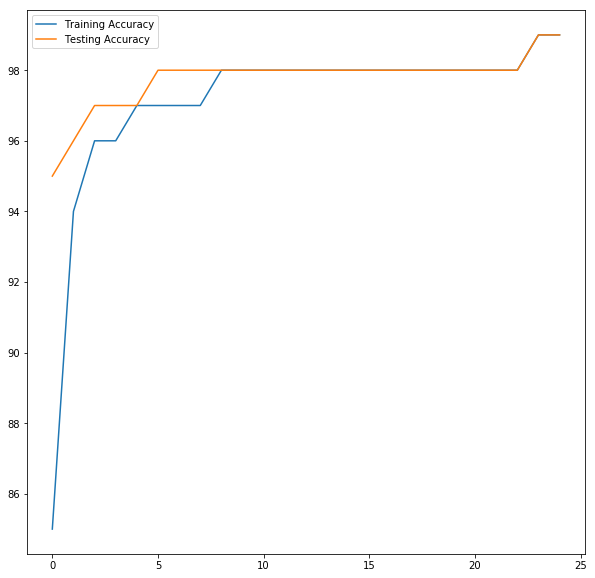

In [22]:
# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(trainAccuracy, label='Training Accuracy')
plt.plot(testAccuracy, label='Testing Accuracy')
plt.legend()
plt.show()

In [25]:
img = testDs[30][0].resize_((1, 1, 28, 28))   #(batch_size,channels,height,width)
img = Variable(img)
label = testDs[30][1]

model.eval()

if torch.cuda.is_available():
    model = model.cuda()
    img = img.cuda()
    
output = model(img)
print(output)
print(output.data)
_, predicted = torch.max(output,1)
print("Prediction is: ", predicted.item())
print("Actual is is : ", label)

tensor([[-5.8519, -3.7816, -0.0913, 14.8118, -5.2971,  4.3210, -7.6450,  1.3923,
          0.6289,  4.6584]], grad_fn=<AddmmBackward>)
tensor([[-5.8519, -3.7816, -0.0913, 14.8118, -5.2971,  4.3210, -7.6450,  1.3923,
          0.6289,  4.6584]])
Prediction is:  3
Actual is is :  3
